# Restauración de Imágenes
Sea $f(x,y)$ una imagen a escala de grises, que ha sido modificada, alterada la calidad de la imagen. Ejemplo
- Mover una cámara cuando se toma una foto.
- Modificaciones geométricas.

Adicionalmente, la imagen puede contener un tipo de ruido aditivo. En resumen, una imagen $f(x,y)$ se puede modificar de 2 maneras:
- Distorción geométrica o de movimiento. (Degradación)
- Ruido aditivo. (Ruido)

![title](media/restauracion-imagenes.svg)

Matemáticamente, la degradación de una imagen se describe de las siguientes maneras:
\begin{equation}
\text{1. } g(x,y) = f(x,y)*h(x,y)+n(x,y)
\end{equation}

\begin{equation}
\text{2. } g(x,y) = h(x,y) \cdot f(x,y) + n(x,y)
\end{equation}

En el primer caso, por el teorema de convolución se tiene que

\begin{equation}
G(u,v)=F(u,v) \cdot H(u,v) + N(u,v)
\end{equation}

donde $G$, $F$, $H$, $N$ son las DFT-2D de $g$, $f$, $h$ y $n$.

## Filtro de Restauración
Es un filtro para poder reconstruir la imagen $f(x,y)$ de la imagen $g(x,y)$. Normalmente, el filtro de restauración sigue los siguientes pasos: <br>
1) Recolectar información del proceso de degradación. (Utilizando muestras) <br>
2) Usando la información recolectada, se construye un modelo de degradación. (Función $D$) <br>
3) Desarrollar un modelo inverso (función $D^{-1}$) y mpodelar ese modelo como un filtro. <br>

## Ruido en una Imagen
El ruido en una images es una función $n(x,y)$ que contamina una imagen original. El ruido es algo no deseado que altera el comportamiento de la imagen original.

Se considerará el ruido como una variable aleatoria, cuya función de probabilidad de densidad (FPD) describe la forma y distribución de los valores de las variables aleatorias.

**Nota.** Se trabajará en el ruido aplicado en el dominio espacial.

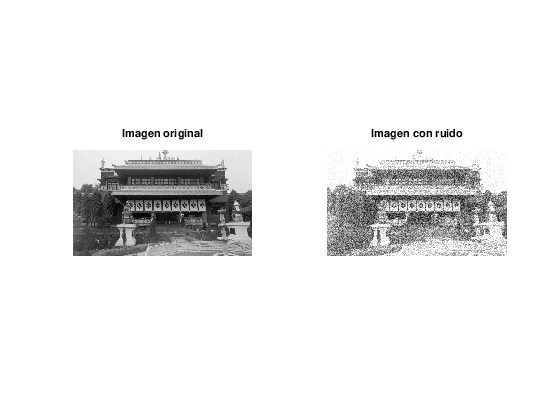

In [1]:
clc; clear; close all;
pkg load image;
A = imread('media/edificio_china.jpg');
subplot(1,2,1);
A = im2double(A);
imshow(A);
title('Imagen original');

% Ruido con distribucion uniforme M=A+N, donde
% N toma valores en el intervalo [0, 1]
% Nota: se recomienda trabajar las imagenes en double
% con valor en [0, 1]
[m,n] = size(A);
N = 0.5*rand(m,n); % Matriz aleatoria con valores en [0,1]
M=A+N;
subplot(1,2,2);
F = im2uint8(M); % Convertir una imagen en formato de 8 bits
imshow(F);
title('Imagen con ruido');

## Diferentes tipos de ruido

\begin{array}{|c|c|c|c|} \hline
\text{Tipo de ruido} & \text{Función de densidad}  & \text{Función acumulada} & \text{Cómo generar matrices aleatorias} \\\hline
\text{Gaussiano}  & f_x(z)=\dfrac{1}{\sqrt{2 \pi \sigma }} \cdot e^{\left(\dfrac{-(z-\overline{z})^2}{2 \sigma^2} \right)} & \theta(z)=\dfrac{1}{\sqrt{2\pi}} \cdot \int_{-\infty}^{z}e^{\left(\dfrac{-x^2}{2}\right)}dx & randn(m,n) \\
\:  & \overline{z} \text{: valor esperado, } \sigma \text{: desviación estándar} & \text{si } \overline{z}=0 \text{ y } \sigma=1 & \text{Matriz $m \times n$ con distribución gaussiana} \\\hline
\text{Uniforme} & \begin{equation} f_x(z)=\begin{cases}
\dfrac{1}{b-a} & \text{ si } z \in [a,b] \\
0 & \text{ si } z \notin [a,b] 
\end{cases} \end{equation} & \theta(z)=\begin{cases}
0 & \text{ si } z < a \\
\dfrac{z-a}{b-a} & \text{ si } z \in [a,b] \\
1 & \text{ si } z > b
\end{cases} & rand(m,n) \\
\: & \: & \: & \text{Matriz $m \times n$ con distribución uniforme} \\\hline
\text{Rayleigh} & f_x(z)=\dfrac{z}{\sigma^2} \cdot e^{\left( \dfrac{-z^2}{2\sigma^2} \right)} & \theta(z)=1-e^{\left( \dfrac{-x^2}{2\sigma^2}\right)} & \text{Obtenido con una técnica numérica} \\
\: & \sigma \text{ es un parámetro} & \: & \: \\\hline
\text{Exponencial} & f_x(z)=\begin{cases}
ae^{-az} & \text{ si } z \geq 0 \\
0 & \text{ si } z < 0
\end{cases} & \theta(z)=1-e^{ax} & \text{Obtenido con una técnica numérica} \\
\: & a \text{ es un parámetro} & \: & \: \\\hline
\text{Sal y Pimienta} & f_x(z)=\begin{cases}
P_p & \text{ si } z = p \\
P_s & \text{ si } z = s \\
0   & \text{ si } z \neq p \wedge z \neq s 
\end{cases} & \: & \text{Tarea} \\
\: & \text{$P_s$: probabilidad de $1$, $P_p$: probabilidad de $0$} & \: & \: \\\hline
\end{array}

Para los ruidos de Rayleigh y Exponencial, GNU Octave no tiene implementada una función para generar matrices aleatorias siguiendo una distribución de Rayleigh o Exponencial.

Un proceso numérico para generar un valor aleatorio, conociendo la función acumulada de distribución es el siguiente: <br>
1) Generar un valor aleatorio con distribución uniforme, entre $[0,1]$. Sea este número $x_i$ <br>
2) $z_i=F^{-1}(x_i)$, donde $F$ es la función de distribución acumulada. 

**Nota.** $z_i$ es una aproximación de una variable aleatoria que sigue una función de densidad $f$, cuya función acumulada es $F$.

**Ejemplo.** Función exponencial

\begin{equation}
\theta(z)=1-e^{-\alpha z}
\end{equation}

\begin{equation}
y = 1 - e^{-\alpha z}
\end{equation}

\begin{equation}
e^{-\alpha z} = 1 - y
\end{equation}

\begin{equation}
-\alpha z = ln(1-y)
\end{equation}

\begin{equation}
z = \dfrac{ln(1-y)}{-\alpha}
\end{equation}

\begin{equation}
\theta^{-1}(z) = \dfrac{-1}{\alpha} ln(1-z)
\end{equation}

\begin{equation}
z \in ]0,1[
\end{equation}

In [2]:
function Z = rand_e(m,n,alpha)
  % Genera una matriz pseudoaleatoria de dimensiones mxn que
  % sigue una funcion de densidad exponencial con parametro alpha
  U = rand(m,n);
  Z = (-1/alpha)*log(1-U);
endfunction

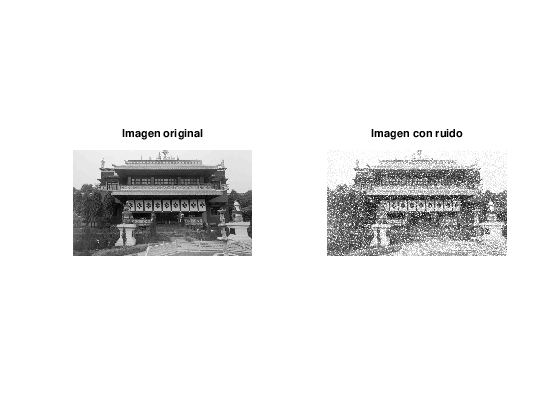

In [3]:
clc; clear; close all;
pkg load image;
A = imread('media/edificio_china.jpg');
subplot(1,2,1);
A = im2double(A);
imshow(A);
title('Imagen original');

% Ruido con distribucion uniforme M=A+N, donde
% N toma valores en el intervalo [0, 1]
% Nota: se recomienda trabajar las imagenes en double
% con valor en [0, 1]
[m,n] = size(A);
N = 0.1*rand_e(m,n,0.5); % Matriz aleatoria que sigue una distribucion exp
M=A+N;
subplot(1,2,2);
F = im2uint8(M); % Convertir una imagen en formato de 8 bits
imshow(F);
title('Imagen con ruido');

In [4]:
function Z = salt_and_pepper(m, n, p)
  % Funcion para generar un ruido de sal y pimienta
  % m: numero de filas, double
  % n: numero de columnas, double
  % p: probabilidad de cambiar un pixel, double entre 0 y 1
  Z = zeros(m,n);
  p = p*100;
  x = randi([0, 100], [m, n]);
  for i = 1:m
    for j = 1:n
      if (x(i,j) < p)
        Z(i,j) = randi([-1, 1]);
      endif
    endfor
  endfor
endfunction

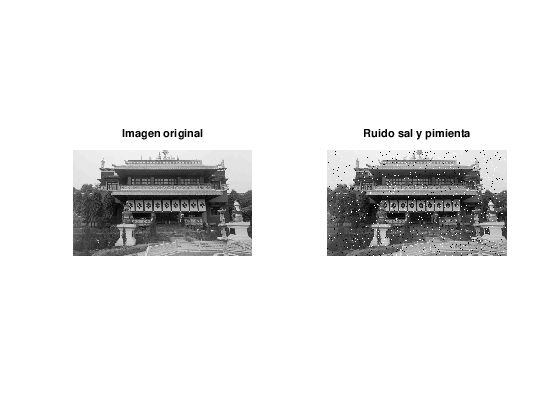

In [5]:
clc; clear; close all;
pkg load image;

A = imread('media/edificio_china.jpg');
subplot(1,2,1);
A = im2double(A);
imshow(A);
title('Imagen original');

[m,n] = size(A);
Z = salt_and_pepper(m, n, 0.06);
M = A + Z;
subplot(1,2,2);
imshow(M);
title('Ruido sal y pimienta');